# Import

In [497]:
import numpy as np
import pandas as pd
import math, itertools
from itertools import combinations, product
from typing import List, Dict, Tuple, Iterable

from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Polygon
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PatchCollection

import plotly.graph_objects as go
from plotly.colors import sample_colorscale

import torch
import cvxpy as cp
import torch.nn.functional as F
from scipy.optimize import linprog
from scipy.optimize import minimize

from dnn_dro import (make_rng, manual_seed_all, gaussian, 
                     spec_norm, batched_spec_norm,
                     relu, softmax, cross_entropy, 
                     global_L, local_L)

ImportError: cannot import name 'batched_spec_norm' from 'dnn_dro' (c:\Users\lechi\Documents\VinUniversity\Research Assistantship\Hong T. M. Chu\WDRO4NN\dnn_dro\__init__.py)

# Toy Case

In [43]:
# Shared functions: build random 2-layer ReLU network
def init_experiment(seed, n=4, n1=3, K=3, device="cpu"):
    g = g = make_rng(seed, device=device)
    W1 = gaussian((n1, n), rng=g, device=device)
    W2 = gaussian((K , n1), rng=g, device=device)
    x  = gaussian((n,), rng=g, device=device)

    # Jacobian norm at x
    D  = torch.diag((W1 @ x > 0).float())
    Jn = spec_norm(W2 @ D @ W1)

    # Global Lipschitz constant L = √2 * max_D ‖W2 D W1‖
    masks = torch.tensor([[ (i >> k) & 1 for k in range(n1) ]
                          for i in range(2**n1)],
                         dtype=torch.float32, device=device)
    sqrt2 = torch.sqrt(torch.tensor(2.0, device=device))
    L = sqrt2 * torch.stack([spec_norm(W2 @ torch.diag(m) @ W1)
                             for m in masks]).max()

    return dict(rng=g, W1=W1, W2=W2, x=x, Jn=Jn, L=L, sqrt2=sqrt2)

# Cross-entropy loss for one vector
def ce_loss(vec, W1, W2, target_cls=1):
    logits = (W2 @ relu(W1 @ vec)).unsqueeze(0)
    target = torch.tensor([target_cls], device=vec.device)
    return cross_entropy(logits, target)

## Checking Inequalities

| **column in the DataFrame** | **what it measures**                                                                      | **inequality it should satisfy** |
| --------------------------- | ----------------------------------------------------------------------------------------- | -------------------------------- |
| `max_diff_over_grad`        | $\displaystyle\max_{x'}\frac{\lvert\psi(x')-\psi(x)\rvert}{\sqrt2\,\|J\|_2\,\|x'-x\|_2}$ | ≤ 1                              |
| `max_grad_over_L`          | $\displaystyle\max_{x'}\frac{\sqrt2\,\|J\|_2\,\|x'-x\|_2}{L\,\|x'-x\|_2}$              | ≤ 1                              |
| `max_diff_over_L`          | $\displaystyle\max_{x'}\frac{\lvert\psi(x')-\psi(x)\rvert}{L\,\|x'-x\|_2}$             | ≤ 1                              |


In [44]:
def run_mc(seed, *, n=4, n1=3, K=3, trials=400, noise=0.7, device="cpu"):
    ctx = init_experiment(seed, n, n1, K, device)
    g, W1, W2, x, Jn, L, sqrt2 = ctx.values()
    base_loss = ce_loss(x, W1, W2)

    r1 = r2 = r3 = 0.0
    for _ in range(trials):
        x_p = x + noise * gaussian((n,), rng=g, device=device)
        d   = torch.norm(x_p - x)
        if d == 0: continue

        diff   = (ce_loss(x_p, W1, W2) - base_loss).abs()
        bound1 = sqrt2 * Jn * d
        bound2 = L * d

        r1 = max(r1, (diff / bound1).item())
        r2 = max(r2, (bound1 / bound2).item())
        r3 = max(r3, (diff / bound2).item())

    return dict(seed=seed, J_norm=Jn.item(), L=L.item(),
                max_diff_over_grad=r1,
                max_grad_over_L=r2,
                max_diff_over_L=r3)

df_mc = pd.DataFrame([run_mc(s) for s in range(5)])
df_mc

,seed,J_norm,L,max_diff_over_grad,max_grad_over_L,max_diff_over_L
0,0,3.410633,5.602598,0.212022,0.860915,0.182533
1,1,5.326426,9.167764,0.834509,0.821651,0.685675
2,2,2.163410,3.390772,0.271887,0.902309,0.245326
3,3,2.503901,5.091682,0.203883,0.695458,0.141792
4,4,2.743037,4.582976,0.707384,0.846446,0.598762


---

| column name in the DataFrame| what the numbers are|
|---------------------------- | ------------------- |
| `ratio_single`| $\displaystyle\frac{\lvert\psi(x')-\psi(x)\rvert}{\sqrt2\,\|J\|_2\,\|x'-x\|_2}$|
| `ratio_path`| $\displaystyle\frac{\lvert\psi(x')-\psi(x)\rvert}{\sqrt2\,\|J^{(*)}\|_2\,\|x'-x\|_2}$ |
| `ratio_L`| $\displaystyle\frac{\lvert\psi(x')-\psi(x)\rvert}{L\,\|x'-x\|_2}$|
| `n_segs`| how many linear **segments** the straight path $x \to x'$ was broken into|


In [45]:
def run_path(seed, *, n=4, n1=3, K=3, n_pairs=200, grid_pts=300, device="cpu"):
    ctx = init_experiment(seed, n, n1, K, device)
    W1, W2, x, Jn, L, sqrt2 = ctx["W1"], ctx["W2"], ctx["x"], ctx["Jn"], ctx["L"], ctx["sqrt2"]
    base_loss = ce_loss(x, W1, W2)

    recs = []
    for _ in range(n_pairs):
        x_p = x + torch.randn_like(x)
        diff = (ce_loss(x_p, W1, W2) - base_loss).abs()
        dist = torch.norm(x_p - x)

        # Single-cell bound
        b_single = sqrt2 * Jn * dist
        ratio_single = (diff / b_single).item()

        # Pathwise bound
        ts = torch.linspace(0, 1, grid_pts+1, device=device)
        last_x, last_mask = x, (W1 @ x > 0)
        seg_norms, seg_lens = [], []

        for t in ts[1:]:
            xx = x + t * (x_p - x)
            mask = (W1 @ xx > 0)
            if not torch.equal(mask, last_mask):
                seg_norms.append(spec_norm(W2 @ torch.diag(last_mask.float()) @ W1))
                seg_lens.append(torch.norm(xx - last_x))
                last_x, last_mask = xx, mask

        seg_norms.append(spec_norm(W2 @ torch.diag(last_mask.float()) @ W1))
        seg_lens.append(torch.norm(x_p - last_x))

        Jmax = torch.stack(seg_norms).max()
        path_bound = sqrt2 * Jmax * sum(seg_lens)
        ratio_path = (diff / path_bound).item()
        ratio_L    = (diff / (L * dist)).item()

        recs.append(dict(diff=diff.item(),
                         dist=dist.item(),
                         ratio_single=ratio_single,
                         ratio_path=ratio_path,
                         ratio_L=ratio_L,
                         n_segs=len(seg_lens)))
    return pd.DataFrame(recs)

df_path = run_path(0)
df_path.describe()[["ratio_single","ratio_path","ratio_L","n_segs"]]

,ratio_single,ratio_path,ratio_L,n_segs
count,200.000000,200.000000,200.000000,200.000000
mean,0.056393,0.055295,0.048550,1.515000
std,0.045085,0.042459,0.038815,0.664819
min,0.000104,0.000089,0.000089,1.000000
25%,0.023918,0.023918,0.020591,1.000000
50%,0.041997,0.041997,0.036156,1.000000
75%,0.079157,0.077865,0.068148,2.000000
max,0.357216,0.312215,0.307532,4.000000


---

| column                       | what it is|
| ---------------------------- | ------------------------------------------                         |
| **`‖W2‖₂·‖W1‖₂`**            | product of the *individual* spectral norms                         |                
| **`‖W2·W1‖₂`**               | spectral norm of the *full* linear map $W_2W_1$ (no ReLU masking)  |
| **`max‖W2·D·W1‖₂`**          | largest norm over all $2^{\,n_1}$ binary masks $D$                 |
| **`min‖W2·D·W1‖₂`**          | smallest masked norm                                               |
| **`ratio (max / prod)`**     | $\dfrac{\text{max‖W2DW1‖₂}}{\|W_2\|_2\|W_1\|_2}$                   |
| **`ratio (max / full)`**     | $\dfrac{\text{max‖W2DW1‖₂}}{\|W_2W_1\|_2}$                         |


In [47]:
def compare_norms(seed: int, n: int = 4, n1: int = 3, K: int = 3, device="cpu"):
    # use shared initializer
    ctx = init_experiment(seed, n=n, n1=n1, K=K, device=device)
    W1, W2 = ctx["W1"], ctx["W2"]

    # individual layer norms
    norm_W1 = spec_norm(W1)
    norm_W2 = spec_norm(W2)
    prod_norm = norm_W1 * norm_W2               # ‖W₂‖₂·‖W₁‖₂

    # full linear map
    full_norm = spec_norm(W2 @ W1)              # ‖W₂W₁‖₂

    # enumerate all binary masks (2^n1)
    masks = torch.tensor([[ (i >> k) & 1 for k in range(n1) ]
                          for i in range(2**n1)],
                         dtype=torch.float32, device=device)
    mask_norms = torch.stack([spec_norm(W2 @ torch.diag(m) @ W1) for m in masks])
    max_mask = mask_norms.max()
    min_mask = mask_norms.min()

    return {
        "seed": seed,
        "‖W₂‖₂·‖W₁‖₂": prod_norm.item(),
        "‖W₂W₁‖₂": full_norm.item(),
        "max‖W₂DW₁‖₂": max_mask.item(),
        "min‖W₂DW₁‖₂": min_mask.item(),
        "ratio (max / prod)": (max_mask / prod_norm).item(),
        "ratio (max / full)": (max_mask / full_norm).item() if full_norm > 0 else float("nan")
    }

# Run for multiple seeds
df = pd.DataFrame(compare_norms(s) for s in range(5))
df

,seed,‖W₂‖₂·‖W₁‖₂,‖W₂W₁‖₂,max‖W₂DW₁‖₂,min‖W₂DW₁‖₂,ratio (max / prod),ratio (max / full)
0,0,6.336818,3.700935,3.961635,0.0,0.625177,1.070442
1,1,8.472053,6.397124,6.482588,0.0,0.765173,1.013360
2,2,4.141385,2.397638,2.397638,0.0,0.578946,1.000000
3,3,3.784182,3.600363,3.600363,0.0,0.951424,1.000000
4,4,5.681056,3.240654,3.240654,0.0,0.570431,1.000000


## Compare with Rui Gao

Rui Gao
$$
\left| \mathcal R_{\mathbb P_n,2}(\rho_n;f_\theta)-\rho_n\,\left\|\left\|\nabla f_\theta\right\|_{*}\right\|_{\mathbb P_n,2} \right|
\;\le\;
C_1\rho_n^{\!2}
\;+\;
C_2\,d_1\sqrt{\frac{d}{n}}
\;+\;
\rho_n\sqrt{\frac{t}{2n}}
$$
$$
\mathcal R_{\mathbb P_N,2}(\delta;\psi_\beta) = \sup_{\mathbb{P} \in \mathfrak{M}_1} \left\{\text{E}_\mathbb{P}[\psi_\beta(Z)]\right\} - \text{E}_{\mathbb{P}_N}[\psi_\beta(Z)] 
$$
$$
\sup_{\mathbb{P} \in \mathfrak{M}_1} \left\{\text{E}_\mathbb{P}[\psi_\beta(Z)]\right\} - \text{E}_{\mathbb{P}_N}[\psi_\beta(Z)] \leq \delta\,\left\|\left\|\nabla \psi_\beta\right\|_{*}\right\|_{\mathbb P_N,2} + C_1\delta^{2}
\;+\;
C_2\,n_1\sqrt{\frac{n}{N}}
\;+\;
\delta\sqrt{\frac{t}{2N}}
$$
$$
C_1=\tfrac18, \quad C_2=\sqrt3.
$$
$$
\sup_{\mathbb{P} \in \mathfrak{M}_1} \left\{\text{E}_\mathbb{P}[\psi_\beta(Z)]\right\} - \text{E}_{\mathbb{P}_N}[\psi_\beta(Z)] \leq \delta\,\left\|\left\|\nabla \psi_\beta\right\|_{*}\right\|_{\mathbb P_N,2} + \tfrac18\delta^{2}
\;+\;
\sqrt3\,n_1\sqrt{\frac{n}{N}}
\;+\;
\delta\sqrt{\frac{t}{2N}}
$$

Our Problem
$$
\sup_{\mathbb{P} \in \mathfrak{M}_1} \left\{\text{E}_\mathbb{P}[\psi_\beta(Z)]\right\} - \text{E}_{\mathbb{P}_N}[\psi_\beta(Z)] 
\leq L\,\delta
\;
$$
$$
\mathfrak{M}_1 := \{\mathbb{P}\in \mathcal{P}(\mathcal{Z}) \ | \ \mathcal{W}_{d,1}(\mathbb{P}, \mathbb{P}_N) \leq \delta \}
$$

In [53]:
# Compute theoretical, GCK, and empirical LHS
def compare_bounds(
    seeds=range(10),
    Ns=torch.logspace(1, 4, steps=4, base=10).to(torch.int).tolist(),
    *,
    n=4, n1=3, K=3,
    delta0=0.3, t=1.0,
    constant_radius=False,
    device="cpu"
):
    rows = []
    for seed in seeds:
        # fixed network per seed
        ctx = init_experiment(seed, n=n, n1=n1, K=K, device=device)
        W1, W2, L_net = ctx["W1"], ctx["W2"], ctx["L"]

        for N in Ns:
            # radius scaling
            delta_N = delta0 / math.sqrt(N)
            effective_delta = delta0 if constant_radius else delta_N

            # sample data
            g = make_rng(seed + 1000 + N, device=device)
            X = gaussian((N, n), rng=g, device=device)
            Y_idx = torch.randint(0, K, (N,), generator=g, device=device)
            Y = torch.eye(K, device=device)[Y_idx]

            grad_sq, worst_diffs = [], []
            for x, y in zip(X, Y):
                a1  = W1 @ x
                D   = torch.diag((a1 > 0).float())
                z   = W2 @ relu(a1)
                p   = torch.softmax(z, dim=0)
                gvec = (p - y) @ W2 @ D @ W1
                gn   = torch.norm(gvec)
                grad_sq.append(gn.item()**2)

                # one-step PGD move
                if gn > 0:
                    x_adv = x + effective_delta * gvec / gn
                    z_adv = W2 @ relu(W1 @ x_adv)
                    p_adv = torch.softmax(z_adv, dim=0)
                    diff  = -torch.log((p_adv * y).sum()) + torch.log((p * y).sum())
                    worst_diffs.append(diff.item())

            grad_emp = math.sqrt(sum(grad_sq) / len(grad_sq))
            lhs_emp  = max(worst_diffs) if worst_diffs else 0.0

            # theoretical bound
            ours = effective_delta * L_net.item()

            # GCK bound
            gck = (delta_N * grad_emp + 0.125 * delta_N**2
                   + math.sqrt(3) * n1 * math.sqrt(n / N)
                   + delta_N * math.sqrt(t / (2 * N)))

            # rescale GCK to δ0-scale if constant radius
            if constant_radius:
                gck *= math.sqrt(N)

            rows.append(dict(seed=seed, N=N, ours=ours, gck=gck, lhs_emp=lhs_emp))
    return pd.DataFrame(rows).groupby("N").mean().reset_index()

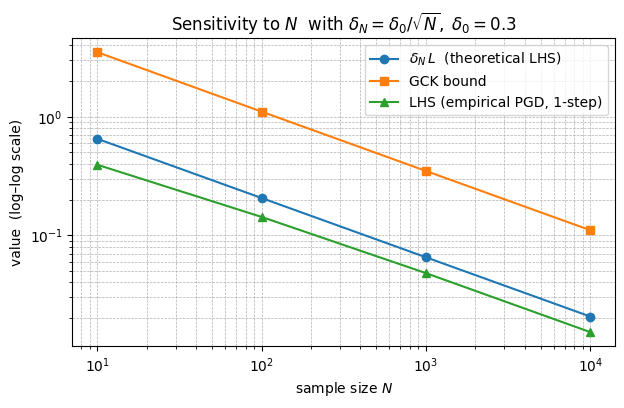

In [54]:
df_decay = compare_bounds(delta0=0.3, constant_radius=False)
plt.figure(figsize=(7,4))
plt.plot(df_decay.N, df_decay.ours,     marker="o", label=r"$\delta_N\,L$  (theoretical LHS)")
plt.plot(df_decay.N, df_decay.gck,      marker="s", label=r"GCK bound")
plt.plot(df_decay.N, df_decay.lhs_emp,  marker="^", label=r"LHS (empirical PGD, 1-step)")
plt.xscale("log"); plt.yscale("log")
plt.xlabel(r"sample size $N$")
plt.ylabel("value  (log-log scale)")
plt.title(rf"Sensitivity to $N$  with $\delta_N=\delta_0/\sqrt{{N}},\;\delta_0={0.3}$")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend()
plt.show()

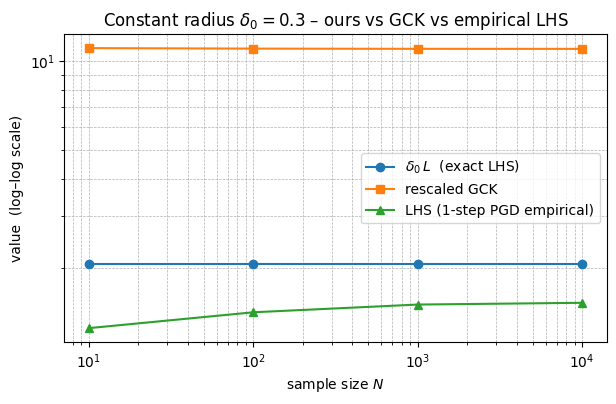

In [55]:
df_const = compare_bounds(delta0=0.3, constant_radius=True)
plt.figure(figsize=(7,4))
plt.plot(df_const.N, df_const.ours,     marker="o", label=r"$\delta_0\,L$  (exact LHS)")
plt.plot(df_const.N, df_const.gck,      marker="s", label=r"rescaled GCK")
plt.plot(df_const.N, df_const.lhs_emp,  marker="^", label=r"LHS (1-step PGD empirical)")
plt.xscale("log"); plt.yscale("log")
plt.xlabel(r"sample size $N$")
plt.ylabel("value  (log–log scale)")
plt.title(rf"Constant radius $\delta_0={0.3}$ – ours vs GCK vs empirical LHS")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.legend()
plt.show()

## Checking Topology

$$\mathcal D = \mathcal D _{(i)}$$

In [59]:
def check_mask_topology(
    n_in=5, n_hidden=6, n_out=1,
    max_random_search=200_000,
    patience=20_000,
    num_samples_segment=120,
    tail_fraction=0.20,
    seed=42,
    device="cpu"
):
    """
    Checks whether 𝓓(i) = 𝓓 for a 1-hidden-layer ReLU network f(x)=W2·ReLU(W1x).
    Returns (bool, D_global, D_i).
    """
    g = make_rng(seed, device=device)

    # random weights
    W1 = torch.randn((n_hidden, n_in), generator=g, device=device)
    W2 = torch.randn((n_out, n_hidden), generator=g, device=device)

    # helpers
    def relu_mask(x: torch.Tensor) -> torch.Tensor:
        return torch.diag((W1 @ x > 0).float())

    def mask_to_int(D: torch.Tensor) -> int:
        bits = (torch.diag(D) > 0).int().cpu().numpy()
        return int("".join(str(b) for b in bits), 2)

    # 1) Monte Carlo: find witnesses for all feasible masks
    witness = {}
    tries_since_new = 0
    for _ in range(max_random_search):
        x = torch.randn((n_in,), generator=g, device=device) * 3
        key = mask_to_int(relu_mask(x))
        if key not in witness:
            witness[key] = x
            tries_since_new = 0
        else:
            tries_since_new += 1
        if tries_since_new > patience:
            break
    D_global = set(witness.keys())
    total_masks = 2 ** n_hidden
    print(f"\n[Step 1] Found {len(D_global)} distinct feasible masks out of {total_masks} possible.")

    # 2) Build 𝓓(i): walk straight segments from x^(i) to each x^D
    x_i = torch.randn((n_in,), generator=g, device=device)
    D_i = set()
    for _, xD in witness.items():
        segment = x_i + torch.linspace(0.0, 1.0, num_samples_segment, device=device).unsqueeze(1) * (xD - x_i)
        tail = segment[int((1 - tail_fraction) * num_samples_segment):]
        for z in tail:
            D_i.add(mask_to_int(relu_mask(z)))

    # 3) Compare & pretty print
    fmt = lambda k: format(k, f"0{n_hidden}b")
    def format_set(S): return "{ " + ", ".join(sorted(fmt(k) for k in S)) + " }"

    print("\n[Step 2] Feasible masks 𝓓:")    ; print(format_set(D_global))
    print("\n[Step 3] Segment-tail masks 𝓓(i):"); print(format_set(D_i))
    equal = D_global == D_i
    print(f"\nResult: 𝓓(i) {'equals' if equal else 'DOES NOT equal'} 𝓓.")
    # return equal, D_global, D_i
    return

# Example run
check_mask_topology()


[Step 1] Found 59 distinct feasible masks out of 64 possible.

[Step 2] Feasible masks 𝓓:
{ 000000, 000001, 000010, 000011, 000100, 000101, 000110, 000111, 001000, 001010, 001011, 001100, 001101, 001110, 001111, 010000, 010010, 010011, 010100, 010101, 010110, 010111, 011000, 011010, 011011, 011100, 011101, 011110, 011111, 100000, 100001, 100010, 100011, 100100, 100101, 100111, 101000, 101001, 101010, 101011, 101100, 101101, 101111, 110000, 110001, 110010, 110011, 110100, 110101, 110110, 110111, 111000, 111001, 111010, 111011, 111100, 111101, 111110, 111111 }

[Step 3] Segment-tail masks 𝓓(i):
{ 000000, 000001, 000010, 000011, 000100, 000101, 000110, 000111, 001000, 001010, 001011, 001100, 001101, 001110, 001111, 010000, 010010, 010011, 010100, 010101, 010110, 010111, 011000, 011010, 011011, 011100, 011101, 011110, 011111, 100000, 100001, 100010, 100011, 100100, 100101, 100111, 101000, 101001, 101010, 101011, 101100, 101101, 101111, 110000, 110001, 110010, 110011, 110100, 110101, 11011

$$
J^*u = w
$$

In [456]:
def build_D2_satisfying(n: int = 2,
                        n1: int = 2,
                        K: int = 2,
                        seed: int = 42,
                        tol: float = 1e-4,
                        device: str = "cpu",
                        max_tries: int = 10000):
    """
    Try to build a network satisfying Assumption (D2).  
    Returns (W1, W2, D_star, J_star, radius, w, u, c, j_plus).
    """
    # --- RNG setup ---
    g = make_rng(seed, device=device)
    manual_seed_all(seed)
    e = torch.eye(K, device=device).numpy()  # Canonical basis

    # --- Fix random c once ---
    c = np.random.default_rng(seed).integers(0, K)

    for _ in range(max_tries):
        # --- Sample W1 and W2 ---
        W1 = gaussian((n1, n), rng=g, device=device).numpy()
        W2 = gaussian((K, n1), rng=g, device=device).numpy()

        # --- Choose D* with max spectral norm ---
        best_val, D_star = -np.inf, None
        for bits in range(2**n1):
            D = np.diag([(bits >> k) & 1 for k in range(n1)])
            val = spec_norm(torch.tensor(W2 @ D @ W1, dtype=torch.float64, device=device)).item()
            if val > best_val:
                best_val, D_star = val, D

        # --- Compute J* ---
        J_star = W2 @ D_star @ W1
        J_star_tensor = torch.tensor(J_star, dtype=torch.float64, device=device)
        if np.linalg.matrix_rank(J_star) < min(n, K):  # Ensure sufficient rank
            continue

        # --- Loop over j+ ≠ c ---
        choices = [j for j in range(K) if j != c]
        for j_plus in choices:
            # --- Compute w ---
            radius = spec_norm(J_star_tensor).item()
            w = (radius / np.sqrt(2)) * (e[j_plus] - e[c])

            # --- Solve for u ---
            try:
                u = np.linalg.solve(J_star, w)
            except np.linalg.LinAlgError:
                continue

            # --- Check (D2): ‖u‖ = 1 and u ∈ Ω ---
            if not np.isclose(np.linalg.norm(u), 1.0, atol=tol):
                continue
            ok = True
            for k in range(n1):
                val = W1[k] @ u
                if D_star[k, k] == 1 and val <= 0: ok = False; break
                if D_star[k, k] == 0 and val >= 0: ok = False; break
            if not ok:
                continue

            return W1, W2, D_star, J_star, radius, w, u, c, j_plus
    
    return None, None, None, None, None, None, None, None, None

In [437]:
def pretty_print_D2(W1, W2, D_star, J_star, radius, w, u, c, j_plus):
    np.set_printoptions(precision=4, suppress=True)
    def banner(text): print(f"\n=== {text} ===")
    def mat(name, M): print(f"{name} =\n{M}\n")

    # Network ingredients
    banner("NETWORK INGREDIENTS")
    mat("W1", W1)
    mat("W2", W2)
    print("D* (bitstring) =", "".join(str(int(x)) for x in np.diag(D_star)))
    mat("D*", D_star)
    mat("J*", J_star)
    print(f"‖J*‖₂ = {radius:.4f}")

    # Strict ReLU cell
    banner("STRICT ReLU CELL 𝒞*")
    for k in range(W1.shape[0]):
        coef = "D*W1" if D_star[k, k] == 1 else "(I−D*)W1"
        sign = ">" if D_star[k, k] == 1 else "<"
        a, b = W1[k].round(4)
        print(f"  {coef}[{k}] · x {sign} 0   (⇒ {a:+.4f}·x₁ {b:+.4f}·x₂ {sign} 0)")

    # Recession cone
    banner("RECESSION CONE rec(𝒞*)")
    for k in range(W1.shape[0]):
        coef = "D*W1" if D_star[k, k] == 1 else "(I−D*)W1"
        cmp = "≥" if D_star[k, k] == 1 else "≤"
        a, b = W1[k].round(4)
        print(f"  {coef}[{k}] · u {cmp} 0   (⇒ {a:+.4f}·u₁ {b:+.4f}·u₂ {cmp} 0)")
    print("Ω = int(rec(𝒞*))  (all inequalities strict)")

    # Image cone
    banner("IMAGE CONE V AND SLICE V*")
    print("V = J* Ω  (linear image of the interior cone)")
    print(f"Sphere radius = ‖J*‖₂ = {radius:.4f}")
    print("V* = V ∩ { z : ‖z‖₂ = ‖J*‖₂ }  (open arc on that circle)")

    # Proof vector
    banner("PROOF VECTOR w & UNIT u")
    print(f"c = {c}, j+ = {j_plus}")
    print("w =", w.round(4))
    print(f"‖w‖₂ = {np.linalg.norm(w):.4f} (matches ‖J*‖₂)")
    print("u =", u.round(4))
    print(f"‖u‖₂ = {np.linalg.norm(u):.4f} (must be 1)")

In [438]:
def compute_a2_data(W1, W2, J_star, Z_i, u, radius, y_true=0, T_max=1000, steps=200, device="cpu"):
    """
    Compute ψ(Z^{(i)} + T u), slope, and ε(T) for Assumption A2.
    """
    W1_t = torch.tensor(W1, dtype=torch.float64, device=device)
    W2_t = torch.tensor(W2, dtype=torch.float64, device=device)
    y = torch.tensor([y_true], device=device)
    
    def ce_loss(x_vec):
        logits = (W2_t @ relu(W1_t @ x_vec)).unsqueeze(0)
        return cross_entropy(logits, y)

    psi_Z_i = ce_loss(torch.tensor(Z_i, dtype=torch.float64, device=device)).item()
    L = np.sqrt(2) * radius

    T_vals = np.linspace(1e-3, T_max, num=steps)
    psi_vals, slopes, epsilons, d_vals = [], [], [], []

    for T in T_vals:
        Z_eps = Z_i + T * u
        psi_T = ce_loss(torch.tensor(Z_eps, dtype=torch.float64, device=device)).item()
        d_val = np.linalg.norm(Z_eps - Z_i)
        slope = (psi_T - psi_Z_i) / d_val
        psi_vals.append(psi_T)
        slopes.append(slope)
        epsilons.append(L - slope)
        d_vals.append(d_val)

    return dict(
        d_vals=d_vals,
        psi_vals=psi_vals,
        slopes=slopes,
        epsilons=epsilons,
        psi_Z_i=psi_Z_i,
        L=L
    )

In [439]:
def plot_assumption_a2(W1, W2, D_star, J_star, Z_i, u, radius, a2_data, w=None, T_max=2):
    d_vals = a2_data["d_vals"]
    psi_vals = a2_data["psi_vals"]
    slopes = a2_data["slopes"]
    epsilons = a2_data["epsilons"]
    psi_Z_i = a2_data["psi_Z_i"]
    L = a2_data["L"]

    # ReLU cell mask for shading
    grid = np.linspace(-8, 8, 1000)
    xx, yy = np.meshgrid(grid, grid)
    cond = np.ones_like(xx, dtype=bool)
    for k in range(2):
        lin = W1[k, 0] * xx + W1[k, 1] * yy
        cond &= lin > 0 if D_star[k, k] == 1 else lin < 0

    # Ray endpoint
    ray_end = Z_i + T_max * u

    # Cone slice
    n = J_star.shape[0]
    Jinv = np.linalg.inv(J_star)
    A = np.vstack([(1 if D_star[k, k] else -1) * (W1[k] @ Jinv) for k in range(n)])
    theta = np.linspace(0, 2*np.pi, 2000, endpoint=False)
    circle_pts = np.c_[np.cos(theta), np.sin(theta)] * radius
    mask = (A @ circle_pts.T > 0).all(axis=0)
    idx_true = np.where(mask)[0]
    splits = np.where(np.diff(idx_true) != 1)[0] + 1
    segments = np.split(idx_true, splits)
    if segments[0][0] == 0 and segments[-1][-1] == len(theta) - 1:
        segments[0] = np.concatenate([segments[-1], segments[0]])
        segments.pop()
    arc_pts = circle_pts[max(segments, key=len)]

    # === FIGURE ===
    fig = plt.figure(figsize=(14, 10))
    gs = fig.add_gridspec(2, 3, height_ratios=[1, 1.2], hspace=0.4, wspace=0.35)

    # Row 1: ReLU cell
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.contourf(xx, yy, cond.astype(int), levels=[0.5, 1.5], alpha=0.2)
    x_line = np.linspace(-8, 8, 900)
    for k in range(W1.shape[0]):
        a, b = W1[k]
        style = '-' if D_star[k, k] else '--'
        if abs(b) > 1e-12:
            ax0.plot(x_line, (-a / b) * x_line, style, lw=1.2)
        else:
            ax0.axvline(0, ls=style, lw=1.2)
    ax0.plot(*Z_i, 'ro'); ax0.text(Z_i[0]+.1, Z_i[1], r'$Z^{(i)}$', color='r')
    ax0.arrow(Z_i[0], Z_i[1], *(ray_end - Z_i), width=0.015,
              head_width=.1, head_length=.15, length_includes_head=True)
    ax0.arrow(0, 0, *u, ls=':', alpha=.5,
              head_width=.07, head_length=.1, length_includes_head=True)
    ax0.set_xlim([-3, 3]); ax0.set_ylim([-3, 3])
    ax0.set_aspect('equal'); ax0.grid(alpha=.3)
    ax0.set_xlabel('$x_1$'); ax0.set_ylabel('$x_2$')
    ax0.set_title('Strict cell $\\mathcal{C}^*$')

    # Row 1: Cone slice
    ax1 = fig.add_subplot(gs[0, 1])
    cone_poly = np.vstack([[0, 0], arc_pts])
    ax1.add_patch(Polygon(cone_poly, closed=True, facecolor="#d62728", alpha=0.18))
    ax1.plot(arc_pts[:, 0], arc_pts[:, 1], color="#d62728", lw=2)
    ax1.add_patch(plt.Circle((0, 0), radius, edgecolor="gray", linestyle="--", facecolor="none"))
    if w is not None:
        ax1.arrow(0, 0, w[0], w[1], color='green', width=0.005,
                  head_width=0.1, head_length=0.16, length_includes_head=True)
        ax1.text(w[0]*1.1, w[1]*1.1, r"$w$", color="green", fontsize=12)
    ax1.set_aspect("equal"); ax1.grid(alpha=0.3)
    ax1.set_title(r"Filled cone slice $V^*$")

    # Row 2: Slope
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(d_vals, slopes); ax2.axhline(y=L, color='red', linestyle='--')
    ax2.set_title('Slope vs $T$'); ax2.grid(alpha=0.3)

    # Row 2: Psi
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.plot(d_vals, psi_vals, color='purple'); ax3.axhline(y=psi_Z_i, color='gray', linestyle='--')
    ax3.set_title(r'$\psi$ vs $T$'); ax3.grid(alpha=0.3)

    # Row 2: Epsilon
    ax4 = fig.add_subplot(gs[1, 2])
    ax4.plot(d_vals, epsilons, color='orange')
    ax4.set_title(r'$\varepsilon(T)$'); ax4.grid(alpha=0.3)

    plt.show()

In [471]:
W1, W2, D_star, J_star, radius, w, u, c, j_plus = build_D2_satisfying(n1=4)
pretty_print_D2(W1, W2, D_star, J_star, radius, w, u, c, j_plus)


=== NETWORK INGREDIENTS ===
W1 =
[[-0.6436  0.3784]
 [ 0.7196  1.7698]
 [ 1.3441  1.0055]
 [-0.351  -0.7537]]

W2 =
[[-0.9808 -0.655  -1.0012 -0.2473]
 [ 0.491  -0.1602  1.8371 -0.1348]]

D* (bitstring) = 0110
D* =
[[0 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 0]]

J* =
[[-1.8171 -2.1659]
 [ 2.354   1.5638]]

‖J*‖₂ = 3.9566

=== STRICT ReLU CELL 𝒞* ===
  (I−D*)W1[0] · x < 0   (⇒ -0.6436·x₁ +0.3784·x₂ < 0)
  D*W1[1] · x > 0   (⇒ +0.7196·x₁ +1.7698·x₂ > 0)
  D*W1[2] · x > 0   (⇒ +1.3441·x₁ +1.0055·x₂ > 0)
  (I−D*)W1[3] · x < 0   (⇒ -0.3510·x₁ -0.7537·x₂ < 0)

=== RECESSION CONE rec(𝒞*) ===
  (I−D*)W1[0] · u ≤ 0   (⇒ -0.6436·u₁ +0.3784·u₂ ≤ 0)
  D*W1[1] · u ≥ 0   (⇒ +0.7196·u₁ +1.7698·u₂ ≥ 0)
  D*W1[2] · u ≥ 0   (⇒ +1.3441·u₁ +1.0055·u₂ ≥ 0)
  (I−D*)W1[3] · u ≤ 0   (⇒ -0.3510·u₁ -0.7537·u₂ ≤ 0)
Ω = int(rec(𝒞*))  (all inequalities strict)

=== IMAGE CONE V AND SLICE V* ===
V = J* Ω  (linear image of the interior cone)
Sphere radius = ‖J*‖₂ = 3.9566
V* = V ∩ { z : ‖z‖₂ = ‖J*‖₂ }  (open arc on t

In [457]:
W1, W2, D_star, J_star, radius, w, u, c, j_plus = build_D2_satisfying(n1=4)
pretty_print_D2(W1, W2, D_star, J_star, radius, w, u, c, j_plus)


=== NETWORK INGREDIENTS ===
W1 =
[[-0.6436  0.3784]
 [ 0.7196  1.7698]
 [ 1.3441  1.0055]
 [-0.351  -0.7537]]

W2 =
[[-0.9808 -0.655  -1.0012 -0.2473]
 [ 0.491  -0.1602  1.8371 -0.1348]]

D* (bitstring) = 0110
D* =
[[0 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 0]]

J* =
[[-1.8171 -2.1659]
 [ 2.354   1.5638]]

‖J*‖₂ = 3.9566

=== STRICT ReLU CELL 𝒞* ===
  (I−D*)W1[0] · x < 0   (⇒ -0.6436·x₁ +0.3784·x₂ < 0)
  D*W1[1] · x > 0   (⇒ +0.7196·x₁ +1.7698·x₂ > 0)
  D*W1[2] · x > 0   (⇒ +1.3441·x₁ +1.0055·x₂ > 0)
  (I−D*)W1[3] · x < 0   (⇒ -0.3510·x₁ -0.7537·x₂ < 0)

=== RECESSION CONE rec(𝒞*) ===
  (I−D*)W1[0] · u ≤ 0   (⇒ -0.6436·u₁ +0.3784·u₂ ≤ 0)
  D*W1[1] · u ≥ 0   (⇒ +0.7196·u₁ +1.7698·u₂ ≥ 0)
  D*W1[2] · u ≥ 0   (⇒ +1.3441·u₁ +1.0055·u₂ ≥ 0)
  (I−D*)W1[3] · u ≤ 0   (⇒ -0.3510·u₁ -0.7537·u₂ ≤ 0)
Ω = int(rec(𝒞*))  (all inequalities strict)

=== IMAGE CONE V AND SLICE V* ===
V = J* Ω  (linear image of the interior cone)
Sphere radius = ‖J*‖₂ = 3.9566
V* = V ∩ { z : ‖z‖₂ = ‖J*‖₂ }  (open arc on t

In [451]:
build_D2_satisfying(n1=2)

(False, None)

In [411]:
Z_i = np.random.uniform(low=-2, high=2, size=2)

In [441]:
a2_data = compute_a2_data(W1, W2, J_star, Z_i, u, radius, y_true=c)

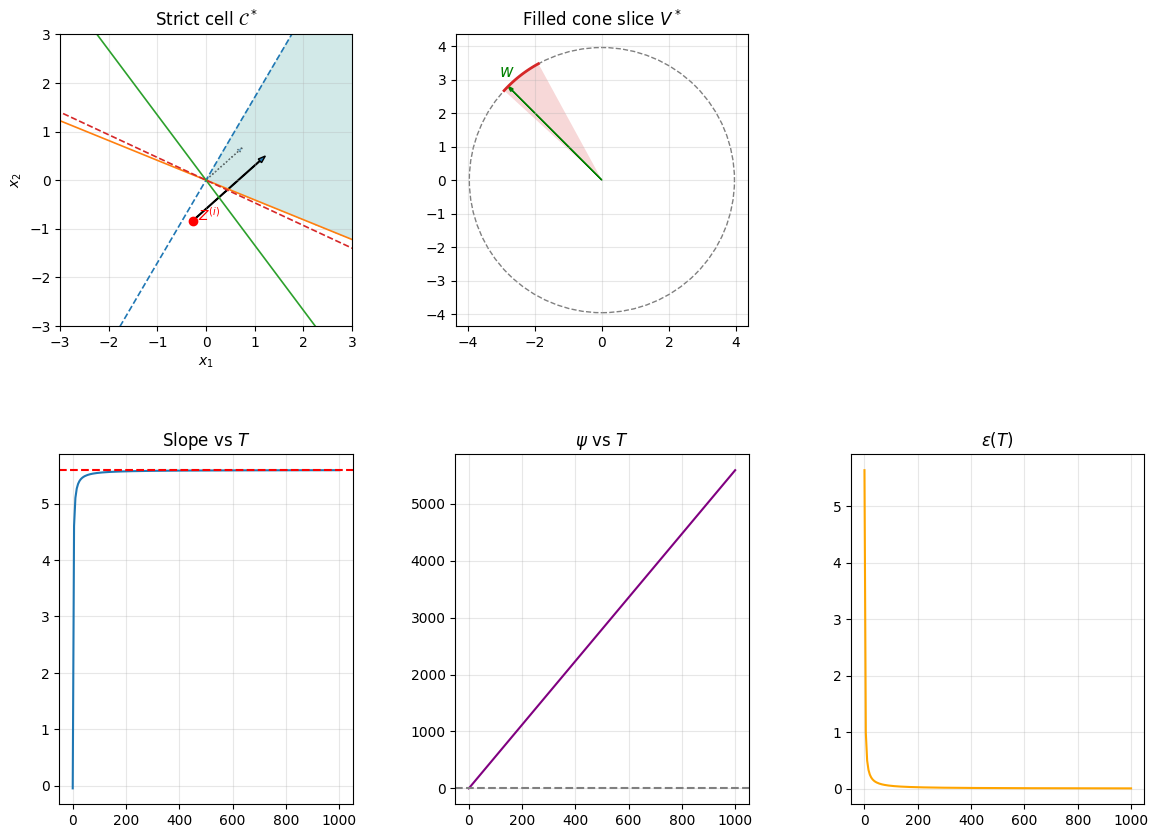

In [442]:
plot_assumption_a2(W1, W2, D_star, J_star, Z_i, u, radius, a2_data, w = w)

## Loss Surface

In [413]:
# ----- parameters ------------------------------------------------
BOX = torch.tensor([-10, 6])     # grid range
pts_all = torch.tensor([[-3,-1],[0,-3],[-2,2],[1,1]], dtype=torch.float32)
labels  = torch.tensor([0,0,1,1])
T_LEN = 5

In [372]:
# Loss surface visualization
# ----- Cross-entropy helper -----
def forward_loss(W1: torch.Tensor, W2: torch.Tensor, X: torch.Tensor, c: int) -> torch.Tensor:
    """Compute cross-entropy loss for inputs X with class label c."""
    logits = W2 @ relu(W1 @ X.T)  # shape: (K, N)
    targets = torch.full((X.shape[0],), c, dtype=torch.long)
    return cross_entropy(logits.T, targets, reduction='none')  # (N,)

# Ensure W1, W2, u are tensors (convert if they are numpy arrays)
if not isinstance(W1, torch.Tensor):
    W1 = torch.tensor(W1, dtype=torch.float32)
else:
    W1 = W1.clone().detach().float()

if not isinstance(W2, torch.Tensor):
    W2 = torch.tensor(W2, dtype=torch.float32)
else:
    W2 = W2.clone().detach().float()

if not isinstance(u, torch.Tensor):
    u = torch.tensor(u, dtype=torch.float32)
else:
    u = u.clone().detach().float()


# ----- 2. compute loss (z-coord) for each sampled point ----------
z_vals = forward_loss(W1, W2, pts_all, c)  # keep as tensor

# ----- 3. build the surface --------------------------------------
grid   = torch.linspace(BOX[0], BOX[1], 200)
xx, yy = torch.meshgrid(grid, grid, indexing='ij')
XY     = torch.stack([xx.reshape(-1), yy.reshape(-1)], dim=1)  # (N,2)
loss_grid = forward_loss(W1, W2, XY, c).reshape(xx.shape)

# ----- 4. plot surface + scatter points -------------------------
fig = go.Figure()

# Loss surface
fig.add_trace(
    go.Surface(
        x=xx.numpy(), y=yy.numpy(), z=loss_grid.numpy(),
        colorscale='Viridis', opacity=0.8,
        showscale=True, colorbar=dict(title='Loss', x=-0.15)
    )
)

# Masks for labels
mask0 = labels == 0
mask1 = ~mask0

# Scatter points (above surface & projections)
for mask in [mask0, mask1]:
    fig.add_trace(go.Scatter3d(
        x=pts_all[mask,0].numpy(), y=pts_all[mask,1].numpy(), z=z_vals[mask].numpy(),
        mode='markers', marker=dict(size=5, color='red'), showlegend=False
    ))
    fig.add_trace(go.Scatter3d(
        x=pts_all[mask,0].numpy(), y=pts_all[mask,1].numpy(), z=torch.zeros_like(z_vals[mask]).numpy(),
        mode='markers', marker=dict(size=4, color='red', symbol='diamond'), showlegend=False
    ))

# Vertical connectors
for (x, y, z) in zip(pts_all[:,0], pts_all[:,1], z_vals):
    fig.add_trace(go.Scatter3d(
        x=[x.item(), x.item()], y=[y.item(), y.item()], z=[0, z.item()],
        mode='lines', line=dict(color='gray', dash='dash'), showlegend=False
    ))

# Witness direction u as arrows
for idx, (x0, y0) in enumerate(pts_all):
    xy0 = torch.tensor([x0, y0])
    xy1 = xy0 + T_LEN * u
    z_end = forward_loss(W1, W2, xy1.unsqueeze(0), c).item()

    # endpoint markers
    fig.add_trace(go.Scatter3d(x=[xy1[0].item()], y=[xy1[1].item()], z=[0],
                               mode='markers', marker=dict(size=2, color='black', symbol='x'), showlegend=False))
    fig.add_trace(go.Scatter3d(x=[xy1[0].item()], y=[xy1[1].item()], z=[z_end],
                               mode='markers', marker=dict(size=2, color='black', symbol='square'), showlegend=False))
    # connectors
    fig.add_trace(go.Scatter3d(
        x=[x0.item(), xy1[0].item()], y=[y0.item(), xy1[1].item()], z=[z_vals[idx].item(), z_end],
        mode='lines', line=dict(color='black'), showlegend=False
    ))
    fig.add_trace(go.Scatter3d(
        x=[xy1[0].item(), xy1[0].item()], y=[xy1[1].item(), xy1[1].item()], z=[0, z_end],
        mode='lines', line=dict(color='gray', dash='dash'), showlegend=False
    ))
    fig.add_trace(go.Scatter3d(
        x=[x0.item(), xy1[0].item()], y=[y0.item(), xy1[1].item()], z=[0, 0],
        mode='lines', line=dict(color='black', width=2), showlegend=False
    ))

# Layout
fig.update_layout(
    title='Loss surface',
    scene=dict(
        xaxis_title='x₁', yaxis_title='x₂', zaxis_title='Loss',
        camera=dict(eye=dict(x=1.5, y=1.4, z=1.0))
    ),
    width=850, height=650
)

fig.show()

## Assumptions Check

$$
\begin{aligned}
&\text{Fix the training label $c \in \{1,...,K\}$, there exists $j_+ \ne c$ and a unit vector $u \in \Omega$, such that}\\
& \hspace{72pt} J^*u = w :=  \frac{\left\|J^*\right\|_2}{\sqrt{2}}(e_{j_+} - e_{c}) \; , \quad \left\|w\right\|_2 = \left\|J^*\right\|_2, \quad w\in V_*\\
&\text{with $e_j$ being the $j$-th canonical basis vector.}
\end{aligned}
$$

In [478]:
def estimate_d2_probability(param_name, param_values, fixed_params, trials=500):
    results = []
    for val in param_values:
        params = fixed_params.copy()
        params[param_name] = val
        success = 0
        for seed in range(trials):
            _, _, _, _, _, _, u, _, _ = build_D2_satisfying(n=params['n'], n1=params['n1'], K=params['K'], 
                                                            seed=seed, max_tries=1)
            if u is not None:
                success += 1
            else:
                continue
        prob = success / trials
        results.append((val, prob, success, trials))
        print(f"{param_name}={val}, prob={prob*100}%, success={success}, trials={trials}")
    return pd.DataFrame(results, columns=[param_name, 'probability', 'success', 'trials'])

In [481]:
# ----- Run experiments -----
trials = 10000
fixed = {'n': 2, 'n1': 2, 'K': 2}

# 1. Sensitivity to n
df_n = estimate_d2_probability('n', [2, 4, 6, 8, 10], fixed, trials)

# 2. Sensitivity to n1
df_n1 = estimate_d2_probability('n1', [2, 4, 6, 8, 10], fixed, trials)

# 3. Sensitivity to K
df_K = estimate_d2_probability('K', [2, 4, 6, 8, 10], fixed, trials)

n=2, prob=0.02%, success=2, trials=10000
n=4, prob=0.0%, success=0, trials=10000
n=6, prob=0.0%, success=0, trials=10000
n=8, prob=0.0%, success=0, trials=10000
n=10, prob=0.0%, success=0, trials=10000
n1=2, prob=0.02%, success=2, trials=10000
n1=4, prob=0.0%, success=0, trials=10000
n1=6, prob=0.0%, success=0, trials=10000
n1=8, prob=0.0%, success=0, trials=10000


KeyboardInterrupt: 

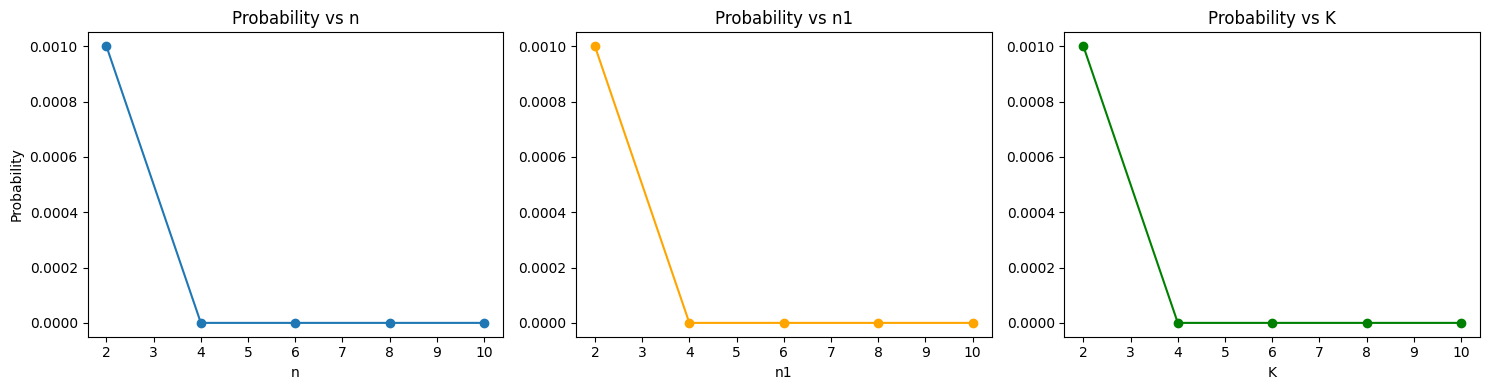

In [480]:
# ----- Plotting -----
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(df_n['n'], df_n['probability'], marker='o')
plt.title('Probability vs n')
plt.xlabel('n'); plt.ylabel('Probability')

plt.subplot(1, 3, 2)
plt.plot(df_n1['n1'], df_n1['probability'], marker='o', color='orange')
plt.title('Probability vs n1')
plt.xlabel('n1')

plt.subplot(1, 3, 3)
plt.plot(df_K['K'], df_K['probability'], marker='o', color='green')
plt.title('Probability vs K')
plt.xlabel('K')

plt.tight_layout()
plt.show()